#Face Recogntion project

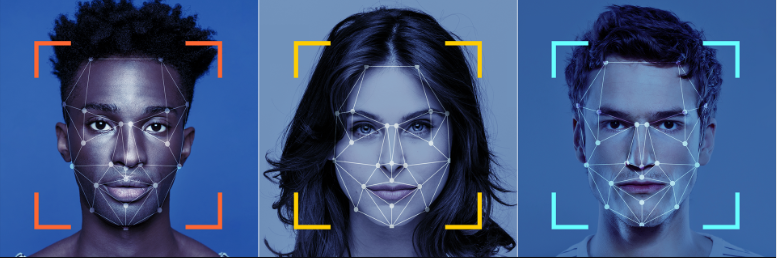

Обычно система распознавания лиц состоит из трех элементов:

- детекция лица (face detection);
- выравнивание лица (face alignment);
- распознавания лица (face recognition).

In [3]:
import pickle
import numpy as np
from skimage import io
import pandas as pd

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path
import math

from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms.functional as TF


from matplotlib import colors, pyplot as plt
%matplotlib inline

import torch
import torchvision
from torch.optim import lr_scheduler
from torchvision.io import read_image

from skimage.io import imread
from skimage.transform import resize
import os

#Загрузка датасета

- В датасете данные лиц 500 людей CelebA-500. Они уже выровнены.
    Внутри:
        - celebA_imgs — папка с выровненными картинками;
        - celebA_anno.txt — файл с аннотацией — каждой картинке из celebA_imgs поставлен в соответствие ее id;
        - celebA_train_split.txt — файл со сплитом на train/val/test.
    Эти данные — часть открытого датасета [CelebA](https://colab.research.google.com/corgiredirector?site=https%3A%2F%2Fmmlab.ie.cuhk.edu.hk%2Fprojects%2FCelebA.html), который один из стандартных для обучения моделей, связанных с лицами.


In [4]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
!unzip -q /content/gdrive/MyDrive/celebA_train_500.zip

In [ ]:
!ls

celebA_train_500  gdrive  __MACOSX  sample_data


In [ ]:
!ls celebA_train_500

celebA_anno.txt  celebA_imgs  celebA_train_split.txt


In [ ]:
anno = {}
with open('celebA_train_500/celebA_anno.txt') as file:
    for line in file:
        key, value = line.split()
        anno[key] = int(value)

In [ ]:
sp = {}
with open('celebA_train_500/celebA_train_split.txt') as file:
    for line in file:
        key, value = line.split()
        sp[key] = int(value)

In [ ]:


train_labels = {}
val_labels = {}
test_labels = {}
root = 'celebA_train_500/celebA_imgs'
files = list(os.walk(os.path.join(root)))[0][2]
for i in range(len(files)):
    if files[i] in anno:
        if sp[files[i]] == 0:
            train_labels[files[i]] = anno[files[i]]
        if sp[files[i]] == 1:
            val_labels[files[i]] = anno[files[i]]
        if sp[files[i]] == 2:
            test_labels[files[i]] = anno[files[i]]

train_labels = pd.DataFrame(list(train_labels.items()), columns = ['img', 'label'])
val_labels = pd.DataFrame(list(val_labels.items()), columns = ['img', 'label'])
test_labels = pd.DataFrame(list(test_labels.items()), columns = ['img', 'label'])
train_labels.head()

,img,label
0,067819.jpg,430
1,103956.jpg,8
2,030591.jpg,232
3,023207.jpg,232
4,029940.jpg,250


In [ ]:
class FaceDataset(Dataset):
    def __init__(self, labels : pd.DataFrame, img_dir, transform=None):
        self.img_labels = labels
        self.img_dir = img_dir
        self.transform = transform


    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = np.array(Image.open(img_path))
        image = Image.fromarray(image[77:-41, 45:-50])
        label = int(self.img_labels.iloc[idx, 1])
        if self.transform:
            image = self.transform(image)
        return image, label

In [ ]:
transform_base = transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize((160, 160), antialias=True),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

train_dataset = FaceDataset(train_labels, root, transform_base)
val_dataset = FaceDataset(val_labels, root, transform_base)
test_dataset = FaceDataset(test_labels, root, transform_base)

In [ ]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

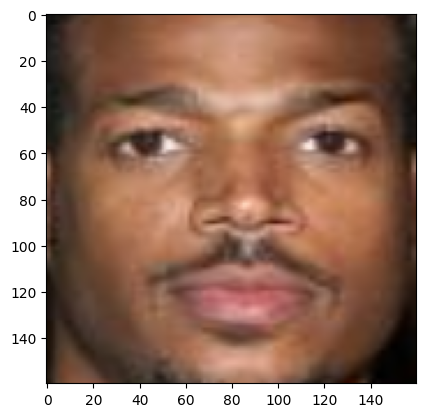

In [ ]:
imshow(train_dataset[0][0])

In [ ]:
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

#Classifier model

Третья часть пайплайна — это, собственно, распознавание лиц.

Что такое "распознавание": мы хотим построить такую нейросеть, которая принимает на вход картинку лица, а выдает вектор определенного размера. И мы хотим, чтобы векторы лиц одного и того же человека были близки по некоторому расстоянию (например, косинусному), а векторы лиц разных людей были далеки по этому же расстоянию. Обычно в качестве расстояния используется [косинусное расстояние](https://en.wikipedia.org/wiki/Cosine_similarity) (cosine distance).

Почему мы хотим построить именно такую сеть? Почему не посмтроить обычную сеть для классификации и научить ее классифицировать лица из обучающей выборки, где каждый отдельный человек — это один класс? Ответ такой — мы хотим, чтобы наша модель умела работать с лицами людей, которых нет в обучающей выборке. Хотим, чтобы она на лица одного и того же незнакомого человека выдавала близкие векторы (т.е. "говорила" нам, что это один и тот же человек), а на лица разных людей — далекие векторы.

Пусть тогда у нас есть база данных людей вида (id, набор векторов его лиц). Когда к нам придет новая картинка лица, мы ее прогоним через модель и получим вектор этого лица. Далее сравним этот вектор по метрике расстояния с векторами из нашей базы. Тот id, чьи векторы будут наиболее близки к нашему, и будет ответом на вопрос "кто изображен на картинке"



In [ ]:
model_classifier = torchvision.models.resnet18(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 81.2MB/s]


In [ ]:
n_classes = 500
model_classifier.fc = nn.Linear(512, n_classes)

In [ ]:
model_classifier.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
len(list(model_classifier.children()))

10

In [ ]:
layers_to_freeze = 0
for i, layer in enumerate(model_classifier.children()):
    if i < layers_to_freeze:
        for param in layer.parameters():
            param.requires_grad = False

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model_classifier.parameters(), lr=0.001, weight_decay=0.1)
scheduler = lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.5)
loaders = {"train": train_loader, "valid": val_loader}

In [ ]:
def train_loop(model, optimizer, criterion, loaders, max_epochs, scheduler=None, use_arcface=False):
    accuracy = {"train": [], "valid": []}
    history = {'epoch': [],
               'train_loss': [], 'val_loss': []}
    for epoch in range(max_epochs):
        for k, dataloader in loaders.items():
            epoch_correct = 0
            epoch_all = 0
            loss = 0
            val_loss = 0
            for x_batch, y_batch in dataloader:
                x_batch, y_batch = x_batch.to(device), y_batch.to(device)
                if k == "train":

                    model.train()
                    optimizer.zero_grad()
                    if use_arcface:
                        outp = model(x_batch, y_batch)
                    else:
                        outp = model(x_batch)
                else:

                    model.eval()
                    with torch.no_grad():
                        outp = model(x_batch)
                        val_loss = criterion(outp, y_batch)
                preds = outp.argmax(-1)
                correct =  torch.sum(y_batch == preds)
                all = len(y_batch)
                epoch_correct += correct.item()
                epoch_all += all
                if k == "train":
                    loss = criterion(outp, y_batch)
                    loss.backward()
                    optimizer.step()
            if k == "train":
                history['train_loss'].append(loss.item())
                history['epoch'].append(epoch)
                print(f"Epoch: {epoch+1}")
            print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
            accuracy[k].append(epoch_correct/epoch_all)
            if k == 'valid':
                history['val_loss'].append(val_loss.item())
        scheduler.step()

    return accuracy, history


In [ ]:
def plot_history(history, acc):
    fig1, axes1 = plt.subplots(nrows=1, ncols=2)

    axes1[0].plot(history['epoch'], history['train_loss'], label='train_loss')
    axes1[0].plot(history['epoch'], history['val_loss'], label='val_loss')
    axes1[0].grid()
    axes1[0].legend()

    axes1[1].plot(history['epoch'], acc['train'], label='train_accuracy')
    axes1[1].plot(history['epoch'], acc['valid'], label='val_accuracy')
    axes1[1].grid()
    axes1[1].legend()

In [ ]:
max_epochs = 10
acc, hist = train_loop(model_classifier, optimizer, criterion, loaders, max_epochs, scheduler)

Epoch: 1
Loader: train. Accuracy: 0.04985955056179775
Loader: valid. Accuracy: 0.077209797657082
Epoch: 2
Loader: train. Accuracy: 0.27305711610486894
Loader: valid. Accuracy: 0.288604898828541
Epoch: 3
Loader: train. Accuracy: 0.5461142322097379
Loader: valid. Accuracy: 0.37859424920127793
Epoch: 4
Loader: train. Accuracy: 0.8724250936329588
Loader: valid. Accuracy: 0.661874334398296
Epoch: 5
Loader: train. Accuracy: 0.9805711610486891
Loader: valid. Accuracy: 0.7082002129925452
Epoch: 6
Loader: train. Accuracy: 0.9987125468164794
Loader: valid. Accuracy: 0.7428115015974441
Epoch: 7
Loader: train. Accuracy: 0.9997659176029963
Loader: valid. Accuracy: 0.7545260915867945
Epoch: 8
Loader: train. Accuracy: 0.9996488764044944
Loader: valid. Accuracy: 0.7561235356762513
Epoch: 9
Loader: train. Accuracy: 0.9998829588014981
Loader: valid. Accuracy: 0.7598509052183173
Epoch: 10
Loader: train. Accuracy: 0.9998829588014981
Loader: valid. Accuracy: 0.7630457933972311


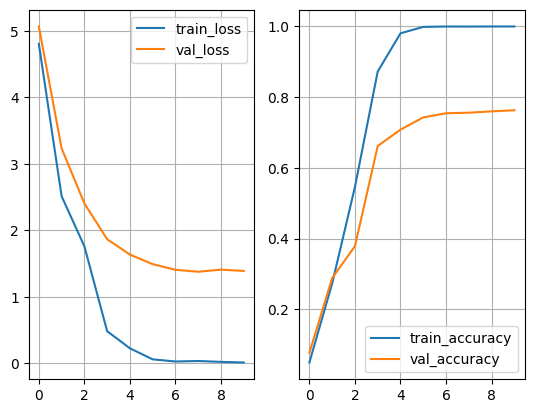

In [ ]:
plot_history(hist, acc)

In [ ]:
def test(model, loader):
    accuracy = 0
    all = 0
    correct = 0
    for x_batch, y_batch in loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)

        model.eval()
        outp = model(x_batch)
        preds = outp.argmax(-1)
        correct +=  torch.sum(y_batch == preds)
        all += len(y_batch)

    return correct / all


In [ ]:
test_acc = test(model_classifier, test_loader)
print(f'Test accuracy = {test_acc}')

Test accuracy = 0.7602265477180481


Мы достигли необходимого accuracy > 0.7 на тестовой выборке

#Identificaton rate metric (TPR@FPR)

При обучении модели для распознавания лиц с помощью CE (кросс-энтропии) мы можем считать метрику accuracy как индикатор того, насколько хорошо наша модель работает. Но у accuracy тут есть недостаток: она не сможет померить, насколько хорошо наша модель работает на лицах людей, которых нет в обучающей выборке.  

Чтобы это исправить, придумали новую метрику: **identification rate**. Вот как она работает:

Создадим два набора изображений лиц: query и distractors. Никакие лица из этих наборов не должны содержаться в обучающем и валидационном датасете.

1. посчитаем косинусные расстояния между лицами, соответствующими одним и тем же людям из query части. Например, пусть одному человеку соответствуют три фото в query: 01.jpg, 02.jpg, 03.jpg. Тогда считаем три косинусных расстояния между всеми тремя парами из этих фото.
2. посчитаем косинусные расстояния между лицами, соответствующими разным людям из query части.
3. посчитаем косинусные расстояния между всеми парами лиц из query и distractors. Т.е. пара — это (лицо из query, лицо из distractors). Всего получится |query|*|distractors| пар.
4. Сложим количества пар, полученных на 2 и 3 шагах. Это количество false пар.
5. Зафиксируем **FPR** (false positive rate). Пусть, например, будет 0.01. FPR, умноженный на количество false пар из шага 4 — это разрешенное количество false positives, которые мы разрешаем нашей модели. Обозначим это количество через N.
6. Отсортируем все значения косинусных расстояний false пар. N — ое по счету значение расстояния зафиксируем как **пороговое расстояние**.
7. Посчитаем количество positive пар с шага 1, которые имеют косинусное расстояние меньше, чем пороговое расстояние. Поделим это количество на общее количество positive пар с шага 1. Это будет TPR (true positive rate) — итоговое значение нашей метрики.

Такая метрика обычно обозначается как TPR@FPR=0.01. FPR может быть разным. Приразных FPR будет получаться разное TPR.

Смысл этой метрики в том, что мы фиксируем вероятность ошибки вида false positive, т.е. когда "сеть сказала, что это один и тот же человек, но это не так", считаем порог косинусного расстояния для этого значения ошибки, потом берем все positive пары и смотрим, у скольких из них расстояние меньше этого порога. Т.е. насколько точно наша сеть ищет похожие лица при заданной вероятности ошибки вида false positive.

In [ ]:
!unzip -q /content/gdrive/MyDrive/celebA_ir.zip

In [ ]:
!ls

celebA_ir  celebA_train_500  gdrive  __MACOSX  sample_data


In [ ]:
from collections import defaultdict

# file with query part annotations: which image belongs to which class
# format:
#     image_name_1.jpg 2678
#     image_name_2.jpg 2679
f = open('./celebA_ir/celebA_anno_query.csv', 'r')
query_lines = f.readlines()[1:]
f.close()
query_lines = [x.strip().split(',') for x in query_lines]
# plain list of image names from query. Neede to compute embeddings for query
query_img_names = [x[0] for x in query_lines]

# dictionary with info of which images from query belong to which class
# format:
#     {class: [image_1, image_2, ...]}
query_dict = defaultdict(list)
for img_name, img_class in query_lines:
    query_dict[img_class].append(img_name)

# list of distractor images
distractors_img_names = os.listdir('./celebA_ir/celebA_distractors')

In [ ]:
len(query_img_names), len(distractors_img_names)

(1222, 2001)

In [ ]:
def compute_embeddings(model, images_list, root):
    '''
    compute embeddings from the trained model for list of images.
    params:
    model: trained nn model that takes images and outputs embeddings
    images_list: list of images paths to compute embeddings for
    output:
    list: list of model embeddings. Each embedding corresponds to images
            names from images_list
    '''
    transform_base = transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize((160, 160), antialias=True),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
    embeddings = []
    for i in images_list:
        img_path = os.path.join(root, i)
        image = np.array(Image.open(img_path))
        image = transform_base(image)
        image = image[None, :, :, :]
        image = image.to(device)
        embeddings.append(model(image))
    return embeddings

In [ ]:
query_size = 100 #памяти не хватает, поэтому возьмем не все изображения
distractions_size = 150
query_embeddings = compute_embeddings(model_classifier, query_img_names[:query_size], './celebA_ir/celebA_query')
distractors_embeddings = compute_embeddings(model_classifier, distractors_img_names[:distractions_size], './celebA_ir/celebA_distractors')

In [ ]:
query_embeddings[0].shape

torch.Size([1, 500])

In [ ]:
cos = nn.CosineSimilarity(dim=1)
res = cos(query_embeddings[0], query_embeddings[1])
res.item()

0.9117347002029419

In [ ]:
def compute_cosine_query_pos(query_dict, query_img_names, query_embeddings):
    '''
    compute cosine similarities between positive pairs from query (stage 1)
    params:
    query_dict: dict {class: [image_name_1, image_name_2, ...]}. Key: class in
                the dataset. Value: images corresponding to that class
    query_img_names: list of images names
    query_embeddings: list of embeddings corresponding to query_img_names
    output:
    list of floats: similarities between embeddings corresponding
                    to the same people from query list
    '''
    cos = nn.CosineSimilarity(dim=1)
    cos_sims = []
    for k in query_dict:
        for i in range(len(query_dict[k])):
            if query_dict[k][i] in query_img_names:
                for j in range(i + 1, len(query_dict[k])):
                    if query_dict[k][j] in query_img_names:
                        emb_i = query_embeddings[query_img_names.index(query_dict[k][i])]
                        emb_j = query_embeddings[query_img_names.index(query_dict[k][j])]
                        sim = cos(emb_i, emb_j).item()
                        cos_sims.append(sim)
    return cos_sims


def compute_cosine_query_neg(query_dict, query_img_names, query_embeddings):
    '''
    compute cosine similarities between negative pairs from query (stage 2)
    params:
    query_dict: dict {class: [image_name_1, image_name_2, ...]}. Key: class in
            the dataset. Value: images corresponding to that class
    query_img_names: list of images names
    query_embeddings: list of embeddings corresponding to query_img_names
    output:
    list of floats: similarities between embeddings corresponding
                to different people from query list
    '''
    cos = nn.CosineSimilarity(dim=1)
    cos_sims = []
    keys = list(query_dict.keys())
    for k in range(len(keys)):
        for s in range(k + 1, len(keys)):
            key1 = keys[k]
            key2 = keys[s]
            for i in range(len(query_dict[key1])):
                if query_dict[key1][i] in query_img_names:
                    for j in range(len(query_dict[key2])):
                        if query_dict[key2][j] in query_img_names:
                            emb_i = query_embeddings[query_img_names.index(query_dict[key1][i])]
                            emb_j = query_embeddings[query_img_names.index(query_dict[key2][j])]
                            sim = cos(emb_i, emb_j).item()
                            cos_sims.append(sim)
    return cos_sims

def compute_cosine_query_distractors(query_embeddings, distractors_embeddings):
    '''
    compute cosine similarities between negative pairs from query and distractors
    (stage 3)
    params:
    query_embeddings: list of embeddings corresponding to query_img_names
    distractors_embeddings: list of embeddings corresponding to distractors_img_names
    output:
    list of floats: similarities between pairs of people (q, d), where q is
                    embedding corresponding to photo from query, d —
                    embedding corresponding to photo from distractors
    '''
    cos = nn.CosineSimilarity(dim=1)
    cos_sims = []
    for q in query_embeddings:
        for d in distractors_embeddings:
            sim = cos(q, d).item()
            cos_sims.append(sim)

    return cos_sims

In [ ]:
cosine_query_pos = compute_cosine_query_pos(query_dict, query_img_names[:query_size],
                                            query_embeddings)
cosine_query_neg = compute_cosine_query_neg(query_dict, query_img_names[:query_size],
                                            query_embeddings)
cosine_query_distractors = compute_cosine_query_distractors(query_embeddings,
                                                            distractors_embeddings)


In [ ]:


len(cosine_query_pos), len(cosine_query_neg), len(cosine_query_distractors)

(1140, 3810, 15000)

In [ ]:
test_query_dict = {
    2876: ['1.jpg', '2.jpg', '3.jpg'],
    5674: ['5.jpg'],
    864:  ['9.jpg', '10.jpg'],
}
test_query_img_names = ['1.jpg', '2.jpg', '3.jpg', '5.jpg', '9.jpg', '10.jpg']
test_query_embeddings = torch.FloatTensor([
                    [1.56, 6.45,  -7.68],
                    [-1.1 , 6.11,  -3.0],
                    [-0.06,-0.98,-1.29],
                    [8.56, 1.45,  1.11],
                    [0.7,  1.1,   -7.56],
                    [0.05, 0.9,   -2.56],
])
test_query_embeddings = test_query_embeddings[:, None, :]

test_distractors_img_names = ['11.jpg', '12.jpg', '13.jpg', '14.jpg', '15.jpg']

test_distractors_embeddings = torch.FloatTensor([
                    [0.12, -3.23, -5.55],
                    [-1,   -0.01, 1.22],
                    [0.06, -0.23, 1.34],
                    [-6.6, 1.45,  -1.45],
                    [0.89,  1.98, 1.45],
])

test_distractors_embeddings = test_distractors_embeddings[:, None, :]

test_cosine_query_pos = compute_cosine_query_pos(test_query_dict, test_query_img_names,
                                            test_query_embeddings)
test_cosine_query_neg = compute_cosine_query_neg(test_query_dict, test_query_img_names,
                                            test_query_embeddings)
test_cosine_query_distractors = compute_cosine_query_distractors(test_query_embeddings,
                                                            test_distractors_embeddings)

In [ ]:
test_query_embeddings.shape

torch.Size([6, 1, 3])

In [ ]:
true_cosine_query_pos = [0.8678237233650096, 0.21226104378511604,
                         -0.18355866977496182, 0.9787437979250561]
assert np.allclose(sorted(test_cosine_query_pos), sorted(true_cosine_query_pos)), \
      "A mistake in compute_cosine_query_pos function"

true_cosine_query_neg = [0.15963231223161822, 0.8507997093616965, 0.9272761484302097,
                         -0.0643994061127092, 0.5412660901220571, 0.701307100338029,
                         -0.2372575528216902, 0.6941032794522218, 0.549425446066643,
                         -0.011982733001947084, -0.0466679194884999]
assert np.allclose(sorted(test_cosine_query_neg), sorted(true_cosine_query_neg)), \
      "A mistake in compute_cosine_query_neg function"

true_cosine_query_distractors = [0.3371426578637511, -0.6866465610863652, -0.8456563512871669,
                                 0.14530087113136106, 0.11410510307646118, -0.07265097629002357,
                                 -0.24097699660707042,-0.5851992679925766, 0.4295494455718534,
                                 0.37604478596058194, 0.9909483738948858, -0.5881093317868022,
                                 -0.6829712976642919, 0.07546364489032083, -0.9130970963915521,
                                 -0.17463101988684684, -0.5229363015558941, 0.1399896725311533,
                                 -0.9258034013399499, 0.5295114163723346, 0.7811585442749943,
                                 -0.8208760031249596, -0.9905139680301821, 0.14969764653247228,
                                 -0.40749654525418444, 0.648660814944824, -0.7432584300096284,
                                 -0.9839696492435877, 0.2498741082804709, -0.2661183373780491]
assert np.allclose(sorted(test_cosine_query_distractors), sorted(true_cosine_query_distractors)), \
      "A mistake in compute_cosine_query_distractors function"

In [ ]:
def compute_ir(cosine_query_pos, cosine_query_neg, cosine_query_distractors,
               fpr=0.1):
    '''
    compute identification rate using precomputer cosine similarities between pairs
    at given fpr
    params:
    cosine_query_pos: cosine similarities between positive pairs from query
    cosine_query_neg: cosine similarities between negative pairs from query
    cosine_query_distractors: cosine similarities between negative pairs
                                from query and distractors
    fpr: false positive rate at which to compute TPR
    output:
    float: threshold for given fpr
    float: TPR at given FPR
    '''
    false_pairs = cosine_query_neg + cosine_query_distractors
    false_amount = len(false_pairs)
    N = int(fpr * false_amount)
    false_pairs.sort(reverse=True)
    threshold = false_pairs[N] #чем ближе к 1 тем более похожи
    true_pos = len([x for x in cosine_query_pos if x > threshold])
    TPR = true_pos / len(cosine_query_pos)
    return threshold, TPR

In [ ]:
test_thr = []
test_tpr = []
for fpr in [0.5, 0.3, 0.1]:
  x, y = compute_ir(test_cosine_query_pos, test_cosine_query_neg,
                    test_cosine_query_distractors, fpr=fpr)
  test_thr.append(x)
  test_tpr.append(y)

In [ ]:
test_thr

[-0.011982724070549011, 0.337142676115036, 0.7013070583343506]

In [ ]:
true_thr = [-0.011982733001947084, 0.3371426578637511, 0.701307100338029]
assert np.allclose(np.array(test_thr), np.array(true_thr)), "A mistake in computing threshold"

true_tpr = [0.75, 0.5, 0.5]
assert np.allclose(np.array(test_tpr), np.array(true_tpr)), "A mistake in computing tpr"

In [ ]:
thr = []
tpr = []
fprs = [0.5, 0.2, 0.1, 0.05]
for fpr in fprs:
  x, y = compute_ir(cosine_query_pos, cosine_query_neg,
                    cosine_query_distractors, fpr=fpr)
  thr.append(x)
  tpr.append(y)

In [ ]:
for i in range(len(tpr)):
    print(f'Для датасета с лицами TPR = {tpr[i]} при FPR = {fprs[i]}')

Для датасета с лицами TPR = 0.9859649122807017 при FPR = 0.5
Для датасета с лицами TPR = 0.8947368421052632 при FPR = 0.2
Для датасета с лицами TPR = 0.7605263157894737 при FPR = 0.1
Для датасета с лицами TPR = 0.5973684210526315 при FPR = 0.05


#ArcFaceLoss

В случае с обучением на задачу классификации лосс-функция, которая нам приходит в голову — Cross-Entropy. И на нее действительно можно обучать сеть для распознавания лиц. Но за много лет люди придумали более хитрые лосс-функции, которые делают обучение сети для распознавания лиц более эффективным. Одним из лучших считается ArcFace Loss (Additive Angular Margin Loss).

Этот лосс — чуть измененная кросс-энтропия. Он позволяет достичь лучшего распределения векторов лиц на сфере. В нем добавлены некоторые дополнительные ограничения и гиперпараметры, для того чтобы эмбеддинги лиц одного класса были более близки между собой, а эмбеддинги лиц разных людей оставались далеки. То есть, этот лосс позволяет лучше кластеризовать лица на сфере единичного радиуса.

Оригинальная статья: https://arxiv.org/pdf/1801.07698.pdf


In [ ]:
from torch import linalg

In [ ]:
class ArcFace(nn.Module):
    def __init__(self, in_features, out_features, s=5, m=0.3):
        super().__init__()
        self.s = s
        self.sin_m = torch.sin(torch.tensor(m))
        self.cos_m = torch.cos(torch.tensor(m))
        self.out_features = out_features
        self.fc = nn.Linear(in_features, out_features, bias=False)

    def forward(self, x, label=None):
        w_L2 = linalg.norm(self.fc.weight.detach(), dim=1, keepdim=True).T
        x_L2 = linalg.norm(x, dim=1, keepdim=True)
        cos = self.fc(x) / (x_L2 * w_L2)

        if label is not None:
            sin_m, cos_m = self.sin_m, self.cos_m
            one_hot = F.one_hot(label, num_classes=self.out_features)
            sin = (1 - cos ** 2) ** 0.5
            angle_sum = cos * cos_m - sin * sin_m #cos(a + m)
            cos = angle_sum * one_hot + cos * (1 - one_hot)
            cos = cos * self.s

        return cos

In [ ]:
class MyNet(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        self.n_classes = n_classes

        pretrained_model = torchvision.models.resnet18(pretrained=True)

        self.extractor = nn.Sequential(*list(pretrained_model.children())[:-1])

        self.classifier = ArcFace(512, self.n_classes, s=60, m=0.5)

    def forward(self, x, label=None):
        x = self.extractor(x)

        x = x.view(x.size(0), -1)
        x = self.classifier(x) if label is None else self.classifier(x, label)
        return x

In [ ]:
arc_model = MyNet(500)

In [ ]:
arc_model = arc_model.to(device)

In [ ]:
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(arc_model.parameters(), lr=3e-4, weight_decay=0.1)
scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=1e-5, max_lr=3e-4, cycle_momentum=False, step_size_up=10) #цикличное изменение lr сильно улучшило сходимость
loaders = {"train": train_loader, "valid": val_loader}

In [ ]:
max_epochs = 150
acc_arc, hist_arc = train_loop(arc_model, optimizer, criterion, loaders, max_epochs, scheduler)

Epoch: 1
Loader: train. Accuracy: 0.0024578651685393258
Loader: valid. Accuracy: 0.005324813631522897
Epoch: 2
Loader: train. Accuracy: 0.017322097378277154
Loader: valid. Accuracy: 0.03141640042598509
Epoch: 3
Loader: train. Accuracy: 0.12570224719101122
Loader: valid. Accuracy: 0.1027689030883919
Epoch: 4
Loader: train. Accuracy: 0.37090355805243447
Loader: valid. Accuracy: 0.19382321618743345
Epoch: 5
Loader: train. Accuracy: 0.5905898876404494
Loader: valid. Accuracy: 0.2896698615548456
Epoch: 6
Loader: train. Accuracy: 0.7377106741573034
Loader: valid. Accuracy: 0.3588924387646432
Epoch: 7
Loader: train. Accuracy: 0.8236189138576779
Loader: valid. Accuracy: 0.4126730564430245
Epoch: 8
Loader: train. Accuracy: 0.875
Loader: valid. Accuracy: 0.4504792332268371
Epoch: 9
Loader: train. Accuracy: 0.9149110486891385
Loader: valid. Accuracy: 0.4643237486687966
Epoch: 10
Loader: train. Accuracy: 0.9362125468164794
Loader: valid. Accuracy: 0.4968051118210863
Epoch: 11
Loader: train. Accura

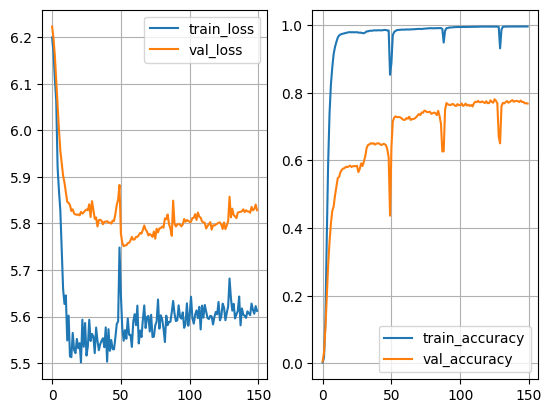

In [ ]:
plot_history(hist_arc, acc_arc)

In [ ]:
arc_test_acc = test(arc_model, test_loader)
print(f'ArcFace model test accuracy = {arc_test_acc}')

ArcFace model test accuracy = 0.7684078216552734


#Face alignment(train)

**Зачем нужна стадия выравнивания**: выравнивание лиц датасета делает задачу распознавания лиц проще для модели на третьей стадии пайплайна. Если у всех лиц, которые принимает на вход модель, примерно одинаковый размер и все ключевые части (глаза, нос, рот) находятся в примерно одинаковых местах, это упрощает модели задачу понимания того, что за человек изображен на картинке. Модели не нужно "искать" глаза, рот и т.п. на картинке.

Практика подтверждает, что это сильно улучшает эффективность модели: без стадии выравнивания практически невозможно обучить хорошую систему распознавания лиц. Точнее, возможно, но только если есть очень-очень-очень много обучающих данных. Больше, чем практически у всех даже больших компаний.

In [1]:
!git clone https://github.com/yinguobing/facial-landmark-dataset/

Cloning into 'facial-landmark-dataset'...
remote: Enumerating objects: 193, done.
remote: Counting objects: 100% (193/193), done.
remote: Compressing objects: 100% (130/130), done.
remote: Total 193 (delta 110), reused 138 (delta 61), pack-reused 0
Receiving objects: 100% (193/193), 53.39 KiB | 5.93 MiB/s, done.
Resolving deltas: 100% (110/110), done.


In [5]:
!unzip -q /content/gdrive/MyDrive/helen.zip

Загрузим датасет HELEN

Размер тренировочной выборки 2000, тестовой 300



In [6]:
import sys

sys.path.insert(0, './facial-landmark-dataset')

from fmd.helen import HELEN
from fmd.mark_dataset.util import draw_marks
from tqdm import tqdm
from google.colab.patches import cv2_imshow

# Set the path to the dataset directory.
HELEN_DIR_TRAIN = "/content/trainset"
HELEN_DIR_TEST = "/content//testset"

# Construct a dataset.
train_ds = HELEN("helen")
test_ds = HELEN("helen")
# Populate the dataset with essential data
train_ds.populate_dataset(HELEN_DIR_TRAIN)
test_ds.populate_dataset(HELEN_DIR_TEST)
# See what we have got.
print(train_ds)

name: helen
authors: Imperial College London
year: 2013
num_marks: 68
num_samples: 2000



/content/./facial-landmark-dataset/fmd/mark_dataset/data_pair.py:40: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if format is "RGB":


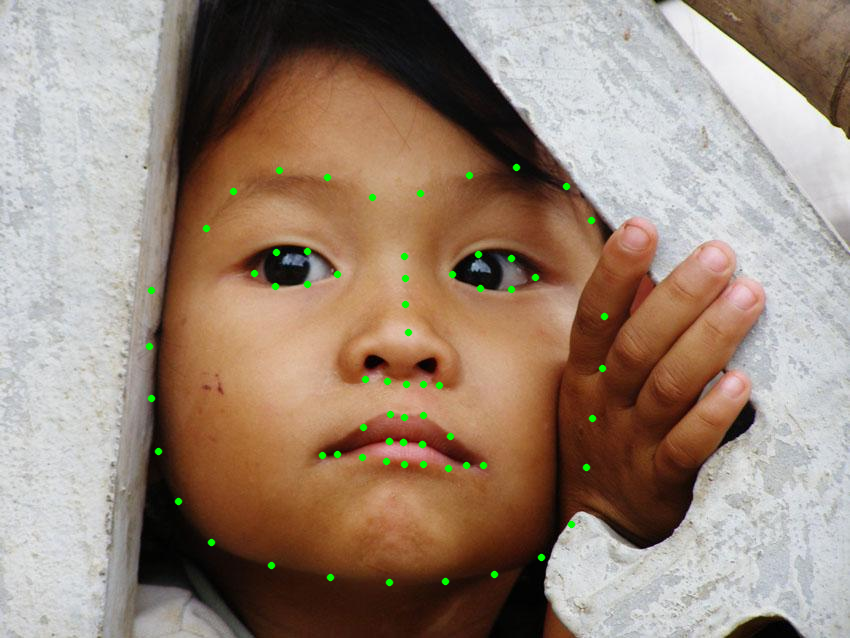

In [9]:
random_sample = train_ds.pick_one()
lucky_image = random_sample.read_image()
draw_marks(lucky_image, random_sample.marks)
cv2_imshow(lucky_image)


In [10]:
random_sample

In [11]:
lucky_image.shape

(638, 850, 3)

In [12]:
random_sample.marks #структура landmarks [x, y, ]


array([[151.570105, 290.11571 ,   0.      ],
       [149.39017 , 346.826591,   0.      ],
       [151.1012  , 398.988096,   0.      ],
       [158.444359, 451.021431,   0.      ],
       [178.600905, 501.547569,   0.      ],
       [211.596001, 542.33564 ,   0.      ],
       [271.807156, 565.128749,   0.      ],
       [330.911268, 577.646373,   0.      ],
       [389.69322 , 582.759865,   0.      ],
       [445.923561, 581.172457,   0.      ],
       [494.07521 , 574.480161,   0.      ],
       [541.224138, 557.712332,   0.      ],
       [571.628609, 524.443152,   0.      ],
       [586.891629, 467.85541 ,   0.      ],
       [592.215524, 418.165406,   0.      ],
       [602.386415, 368.616718,   0.      ],
       [604.528906, 316.227829,   0.      ],
       [206.419802, 228.518439,   0.      ],
       [233.188433, 191.413506,   0.      ],
       [279.24184 , 170.851468,   0.      ],
       [327.196148, 177.239498,   0.      ],
       [372.844626, 197.31937 ,   0.      ],
       [42

**Напишем свой класс датасета, который будет кропать лицо, исходя из landmarks. Ведь мы хотим находить ключевые точки лица после детектирования.**

In [ ]:
class FaceMarkDataset(Dataset):
    def __init__(self, ds : HELEN, size, transform=None, RESIZE_SIZE=None):

        self.images = []
        self.landmarks = []
        self.transform = transform
        self.RESIZE_SIZE = RESIZE_SIZE
        self.size = size
        cnt = 0
        for sample in ds:
            self.images.append(sample)

            landmark = []
            for num in range(68):
                x_coordinate = sample.marks[num, 0]
                y_coordinate = sample.marks[num, 1]
                landmark.append([x_coordinate, y_coordinate])
            self.landmarks.append(landmark)
            cnt += 1
            if cnt == size:
                break

        self.landmarks = np.array(self.landmarks).astype('float32')

        assert len(self.images) == len(self.landmarks)

    def get_box(self, landmarks, img_shape): #Получение bbox лица по данным landmarks
        landmarks_copy = np.array(landmarks)
        bound_size = np.random.randint(15, 40)

        x_min, y_min = landmarks_copy.min(axis=0).round().astype(int)
        x_max, y_max = landmarks_copy.max(axis=0).round().astype(int)

        return (
            max(0, x_min - bound_size),
            max(0, y_min - bound_size),
            min(img_shape[1], x_max + bound_size),
            min(img_shape[0], y_max + bound_size)
        )

    def crop_face(self, image, landmarks, crops): #Кропаем лицо по полученному bbox
        left = crops[0]
        top = crops[1]
        width = crops[2] - crops[0]
        height = crops[3] - crops[1]
        image = TF.crop(image, top, left, height, width)

        img_shape = np.array(image).shape
        landmarks = torch.tensor(landmarks) - torch.tensor([[left, top]])
        landmarks = landmarks / torch.tensor([img_shape[1], img_shape[0]])
        if self.RESIZE_SIZE:
            landmarks *= self.RESIZE_SIZE
        return image, landmarks

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        arr_img = self.images[index].read_image(format="RGB")
        image = Image.fromarray(arr_img)
        landmarks = self.landmarks[index]
        if self.transform:
            bbox = self.get_box(landmarks, arr_img.shape)
            image, landmarks = self.crop_face(image, landmarks, bbox)

            image = self.transform(image)
        return image, landmarks

In [ ]:
RESIZE_SIZE = 160
transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize((RESIZE_SIZE, RESIZE_SIZE), antialias=True),
        ])

In [ ]:
train_ds_torch = FaceMarkDataset(train_ds, 2000, transform, RESIZE_SIZE)
test_ds_torch = FaceMarkDataset(test_ds, 150, transform, RESIZE_SIZE)

In [ ]:
img0 = train_ds_torch[0][0]
lm0 = train_ds_torch[0][1]

In [ ]:
img0

tensor([[[0.2207, 0.2129, 0.2114,  ..., 0.8868, 0.9858, 0.9869],
         [0.2280, 0.2205, 0.2167,  ..., 0.8095, 0.9385, 0.9854],
         [0.2208, 0.2235, 0.2240,  ..., 0.9110, 0.9147, 0.9539],
         ...,
         [0.4661, 0.4584, 0.4337,  ..., 0.2419, 0.2736, 0.2646],
         [0.4450, 0.4369, 0.4294,  ..., 0.2127, 0.2422, 0.2608],
         [0.4332, 0.4257, 0.4164,  ..., 0.1892, 0.2181, 0.2404]],

        [[0.1266, 0.1265, 0.1329,  ..., 0.7804, 0.9500, 0.9908],
         [0.1385, 0.1370, 0.1382,  ..., 0.6361, 0.8506, 0.9566],
         [0.1409, 0.1445, 0.1456,  ..., 0.7641, 0.7978, 0.8748],
         ...,
         [0.3377, 0.3251, 0.3084,  ..., 0.2222, 0.2540, 0.2450],
         [0.3235, 0.3091, 0.3068,  ..., 0.1931, 0.2226, 0.2412],
         [0.3164, 0.3048, 0.2981,  ..., 0.1696, 0.1985, 0.2208]],

        [[0.1201, 0.1106, 0.1057,  ..., 0.6918, 0.8910, 0.9534],
         [0.1259, 0.1159, 0.1108,  ..., 0.5072, 0.7119, 0.8296],
         [0.1165, 0.1183, 0.1182,  ..., 0.5880, 0.5906, 0.

In [ ]:
lm0

tensor([[ 12.0582,  23.8209],
        [ 10.1391,  46.9361],
        [ 10.6335,  72.3993],
        [ 14.8042,  94.4552],
        [ 21.7832, 108.7367],
        [ 32.4211, 124.4923],
        [ 43.3092, 135.9833],
        [ 54.1767, 145.2582],
        [ 65.8107, 148.0497],
        [ 80.3065, 148.5591],
        [ 93.9859, 142.0133],
        [110.7222, 132.4102],
        [125.7896, 123.9275],
        [138.6439, 107.3826],
        [144.8533,  89.8761],
        [146.6579,  74.4982],
        [149.9067,  59.1888],
        [ 29.8060,  15.1428],
        [ 42.9517,  11.2814],
        [ 55.9694,  11.7442],
        [ 68.3740,  14.6990],
        [ 80.5991,  18.9107],
        [ 96.6097,  22.2197],
        [109.8674,  20.4835],
        [122.5035,  21.6209],
        [136.1964,  25.3626],
        [143.8693,  36.8248],
        [ 85.4073,  42.0601],
        [ 83.2564,  53.9853],
        [ 80.8025,  66.2606],
        [ 78.1883,  79.0689],
        [ 64.3055,  85.7461],
        [ 70.9499,  88.9692],
        [ 

**Пример элемента датасета**

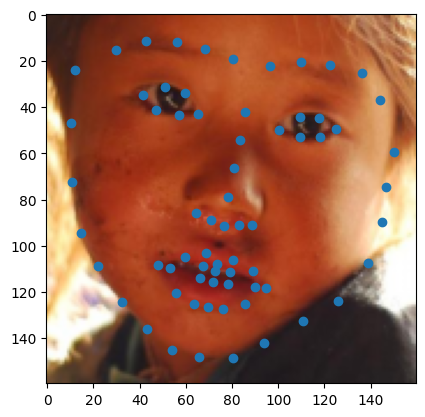

In [ ]:
inp = img0.numpy().transpose((1, 2, 0))
inp = np.clip(inp, 0, 1)
plt.imshow(inp)
plt.scatter(lm0[:, 0], lm0[:, 1])
plt.show()

In [ ]:
train_mark_loader = DataLoader(train_ds_torch, batch_size=16, shuffle=True)

In [ ]:
val_mark_loader = DataLoader(test_ds_torch, batch_size=16, shuffle=False)

**Model for alignment**

In [ ]:
!pip install facenet-pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 11.5 MB/s eta 0:00:00


**Будем использовать модель ResNet18. У линейного слоя будет будет 2 * NUM_PTS выходов, т.к. мы предсказываем координаты x, y для количества точек = NUM_PTS. В нашем датасете их 68**


In [ ]:
class Align_Network(nn.Module):
    def __init__(self, NUM_PTS=68):
        super().__init__()
        #vggface2 = InceptionResnetV1(pretrained='vggface2')
        self.model = torchvision.models.resnet18()
        self.model.fc = nn.Linear(512, 2 * NUM_PTS)
        '''
        self.model = nn.Sequential(
            *list(vggface2.children())[:-4],
            nn.Conv2d(1792, 2*NUM_PTS, 1),
            nn.Flatten(),
            nn.Dropout(0.05),

            nn.Linear(2*NUM_PTS, 2*NUM_PTS),
            nn.LeakyReLU(),
            nn.Dropout(0.05),

            nn.Linear(2*NUM_PTS, 2*NUM_PTS),
            nn.LeakyReLU(),
            nn.Dropout(0.05),

            nn.Linear(2*NUM_PTS, 2*NUM_PTS),
            nn.LeakyReLU(),
            nn.Dropout(0.05),

            nn.Linear(2*NUM_PTS, 2*NUM_PTS),
        )
        '''
    def forward(self, x):
        x=self.model(x)
        return x

In [ ]:
import sys

def print_overwrite(step, total_step, loss, operation):
    sys.stdout.write('\r')
    if operation == 'train':
        sys.stdout.write("Train Steps: %d/%d  Loss: %.4f " % (step, total_step, loss))
    else:
        sys.stdout.write("Valid Steps: %d/%d  Loss: %.4f " % (step, total_step, loss))

    sys.stdout.flush()

In [ ]:
align_model = Align_Network()
align_model = align_model.to(device)

num_epochs = 65
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(align_model.parameters(), lr=0.001)
#scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=1e-5, max_lr=1e-3, cycle_momentum=False, step_size_up=5, step_size_down=10)
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=3, verbose=True)

In [ ]:
def align_train_loop(model, optimizer, criterion, scheduler, train_mark_loader, val_mark_loader, num_epochs):
    losses = {"valid" : [],
              "train" : []}
    for epoch in range(1, num_epochs + 1):

        loss_train = 0
        loss_valid = 0
        running_loss = 0

        model.train()
        for step in range(1, len(train_mark_loader) + 1):

            images, landmarks = next(iter(train_mark_loader))

            images = images.cuda()
            landmarks = landmarks.view(landmarks.size(0), -1).cuda()

            predictions = model(images)

            optimizer.zero_grad()

            loss_train_step = criterion(predictions, landmarks)

            loss_train_step.backward()

            optimizer.step()

            loss_train += loss_train_step.item()
            running_loss = loss_train / step

            print_overwrite(step, len(train_mark_loader), running_loss, 'train')

        model.eval()
        with torch.no_grad():

            for step in range(1,len(val_mark_loader)+1):

                images, landmarks = next(iter(val_mark_loader))

                images = images.cuda()
                landmarks = landmarks.view(landmarks.size(0), -1).cuda()

                predictions = model(images)

                loss_valid_step = criterion(predictions, landmarks)

                loss_valid += loss_valid_step.item()
                running_loss = loss_valid / step

                print_overwrite(step, len(val_mark_loader), running_loss, 'valid')

        loss_train /= len(train_mark_loader)
        loss_valid /= len(val_mark_loader)
        scheduler.step(loss_valid)
        losses["train"].append(loss_train)
        losses["valid"].append(loss_valid)
        print('\n--------------------------------------------------')
        print('Epoch: {}  Train Loss: {:.4f}  Valid Loss: {:.4f}'.format(epoch, loss_train, loss_valid))
        print('--------------------------------------------------')


    print('Training Complete')
    return align_losses

In [ ]:
align_losses = align_train_loop(align_model, optimizer, criterion, scheduler, train_mark_loader, val_mark_loader, num_epochs)

Valid Steps: 10/10  Loss: 428.0473 
--------------------------------------------------
Epoch: 1  Train Loss: 2736.4572  Valid Loss: 428.0473
--------------------------------------------------
Valid Steps: 10/10  Loss: 169.0271 
--------------------------------------------------
Epoch: 2  Train Loss: 181.9802  Valid Loss: 169.0271
--------------------------------------------------
Valid Steps: 10/10  Loss: 127.5210 
--------------------------------------------------
Epoch: 3  Train Loss: 127.0246  Valid Loss: 127.5210
--------------------------------------------------
Valid Steps: 10/10  Loss: 64.3383 
--------------------------------------------------
Epoch: 4  Train Loss: 87.4607  Valid Loss: 64.3383
--------------------------------------------------
Valid Steps: 10/10  Loss: 56.1827 
--------------------------------------------------
Epoch: 5  Train Loss: 65.0447  Valid Loss: 56.1827
--------------------------------------------------
Valid Steps: 10/10  Loss: 44.6255 
---------------

#FaceDetection + alignment

**Здесь воспользуемся готовой моделью для детекции и нашей дообученной сетью для поиска ключевых точек лица. По вектору линии глаз, найдем угол поворота, чтобы глаза были на горизонтальном уровне**

In [ ]:
from facenet_pytorch import MTCNN

In [ ]:
mtcnn = MTCNN(image_size=160, margin=0)

In [ ]:
def show_tensor(tensor_img, axis=plt):
    inp = tensor_img.numpy().transpose((1, 2, 0))
    inp = np.clip(inp, 0, 1)
    axis.imshow(inp)

In [ ]:
def align_image(img, X, Y):
    #https://ibug.doc.ic.ac.uk/resources/facial-point-annotations/ description of landmarks
    eyes_dist = X[42] - X[39]

    eye_vector = torch.FloatTensor([X[45] - X[36], Y[45] - Y[36]])
    horiz_vector = torch.FloatTensor([1, 0])
    eye_vector_n = F.normalize(eye_vector, dim=0) #нормированный вектор, направленный по линии глаз
    angle_for_rotate = torch.arccos(horiz_vector @ eye_vector_n) * 180 / torch.pi
    rot_img = TF.rotate(img, -angle_for_rotate.item()) #поворот против часовой
    return rot_img

In [ ]:
root = "./gdrive/MyDrive/ForAlignment/"
detect_model  = MTCNN(image_size=160, margin=0)
def align_directory(root, detect_model, align_model):
    files = list(os.walk(os.path.join(root)))[0][2]
    fig, axis = plt.subplots(2, len(files))
    for ax in axis.ravel():
        ax.set_axis_off()
    #plt.subplots_adjust(wspace=0.3, hspace=0.01)
    for i in range(len(files)):
        img_name = files[i]
        img_path = os.path.join(root, img_name)
        img = Image.open(img_path)
        detect_face = detect_model(img)
        detect_face_c = detect_face[None, :, :, :].cuda()
        pred_landmarks = align_model(detect_face_c)
        pred_landmarks_d = pred_landmarks.detach().cpu().numpy()[0]
        X = pred_landmarks_d[:-1:2]
        Y = pred_landmarks_d[1::2]
        face_align = align_image(detect_face, X, Y)
        show_tensor(detect_face, axis[0][i])
        axis[0][i].scatter(X, Y, s=5)
        show_tensor(face_align, axis[1][i])

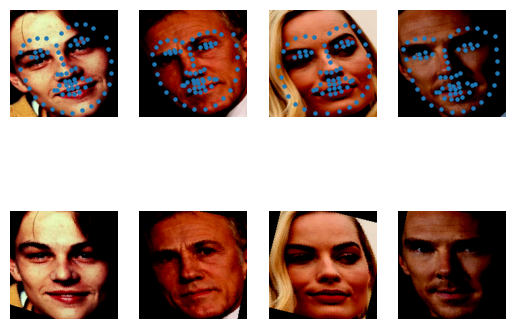

In [ ]:
align_directory(root, detect_model, align_model)

Получаем embeddings

In [ ]:
def give_embeddings(model, test_loader):
    embeddings = torch.FloatTensor()
    iterator = iter(test_loader)
    for i in range(len(test_loader)):
        images = next(iterator)
        images = images[0]
        model.eval()
        with torch.no_grad():
            embd = model.extractor(images.to(device)).view(images.shape[0], -1)
        embeddings = torch.cat((embeddings, embd.cpu()))
    embeddings = F.normalize(embeddings).numpy()
    return embeddings

In [ ]:
embeddings = give_embeddings(arc_model, test_loader)

In [ ]:
embeddings.shape

(1589, 512)